In [1]:
import pandas as pd
import numpy as np
import datetime
import math
from dateutils import relativedelta
from scipy import optimize
from matplotlib import pyplot as plt

In [2]:
valuation_date = datetime.datetime(2019,11,10)

In [3]:
## ------------------------------------------_
## This functions was retrieved from 
## https://github.com/peliot/XIRR-and-XNPV/blob/master/financial.py
## ------------------------------------------_

def xnpv(rate,cashflows):
    chron_order = sorted(cashflows, key = lambda x: x[0])
    t0 = chron_order[0][0]
    return sum([cf/(1+rate)**((t-t0).days/365.0) for (t,cf) in chron_order])

def xirr(cashflows,guess=0.1):
    return optimize.newton(lambda r: xnpv(r,cashflows),guess)

In [4]:
def build_coupon_dates(start_date, frequency, number_periods, end_date, lower_date_threshold=None):
    """
        Right now this function just calculates coupon dates with frequency in Years
    """
    if frequency != 'Y':
        raise Exeception('(build_coupon_dates) So far, this function just works with years as frequency.')
        
    is_over = False
    dates = []
    temporal_date = start_date
    
    if lower_date_threshold is None:
        lower_date_threshold = start_date
    
    while(not is_over):
        if temporal_date <= end_date:
            if temporal_date >= lower_date_threshold:
                dates.append(temporal_date.date())
            temporal_date = temporal_date + relativedelta(years=number_periods)
        else:
            is_over = True
    
    return dates

In [5]:
def build_flows_projection(valuation_date, coupon_rate, nominal, coupon_dates, year_days=365):
    if isinstance(valuation_date, datetime.datetime):
        valuation_date = valuation_date.date()
    df_flows = coupon_dates
    df_flows['period'] = df_flows['date'].apply(lambda x : (x-valuation_date).days/year_days)
    df_flows['payment'] = nominal*coupon_rate
    
    df_flows.loc[len(df_flows)-1,'payment'] += nominal
    
    return df_flows

In [6]:
def calculate_initial_nelson_siegel_rate(coupon_flows, b0, b1, b2, tau):
    df_ns_rates = coupon_flows.copy()
    df_ns_rates['ns_rates'] = df_ns_rates['period']\
                                .apply(
                                    lambda x:
                                        (b0 + ((b1+b2)*((1-math.exp(-x / tau)) / (x/tau))) - b2*math.exp(-x/tau) ) / 100
                                )
    return df_ns_rates

In [7]:
def calculate_present_value(flows):
    df_pv = flows.copy()
    df_pv['present_value'] = [v['payment']*math.exp(-v['period']*v['ns_rates']) for i, v in df_pv.iterrows()]
    return df_pv

In [8]:
def root_mean_squared_error(observed, model):
    diff_ = (np.subtract(observed,model)*10000)**2
    return sum(diff_)

# Nelson and Siegel Model (1987)

In financial industry, people do need to get the term structure of interest rates in a lot point over time, to assets valuation, and another tasks. But this structure could has particular characteristics like we will see in the figure about colombian TES yield curve, like long term level, short term level and convexity and some times inflexion points. This characteristics do the calculations about term structure of interest, some difficult in simplicity, as it could be seen on many methods developed throught 80's and 90's, known as cuadratic and cubic splines by McCulloch (1971) and any others, built with splines structure, and having some critics (<a href="https://pdfs.semanticscholar.org/70c4/20a1dc336394866dff5f206df6cc8274d991.pdf">see this article</a>).

To this, Nelson and Siegel did make one model in 1987 (<b><a href="http://web.math.ku.dk/~rolf/teaching/NelsonSiegel.pdf">original article</a></b>), more simple where looking four parameters, and a specific function, is posible to model forward rates in discrete time. It had an transformation where using the model is posible to get the spot interest rate, applying over forward model, the integration operator.

# Colombian TES Yield Curve

## Data

In [9]:
free_risk_bonds = pd.read_excel('bonds_free_risk.xlsx')

In [10]:
free_risk_bonds

,period,maturity_date,coupon_rate,clean_price,yield_rate
0,0.704110,2020-07-24,0.1100,105570,0.0415
1,2.482192,2022-05-04,0.0700,105348,0.0477
2,4.706849,2024-07-24,0.1000,120446,0.0512
3,6.049315,2025-11-26,0.0625,104090,0.0544
4,6.797260,2026-08-26,0.0750,110910,0.0556
5,8.471233,2028-04-28,0.0600,100951,0.0585
6,10.863014,2030-09-18,0.0775,113546,0.0603
7,12.646575,2032-06-30,0.0700,106976,0.0619
8,14.947945,2034-10-18,0.0725,109163,0.0629


## Plot

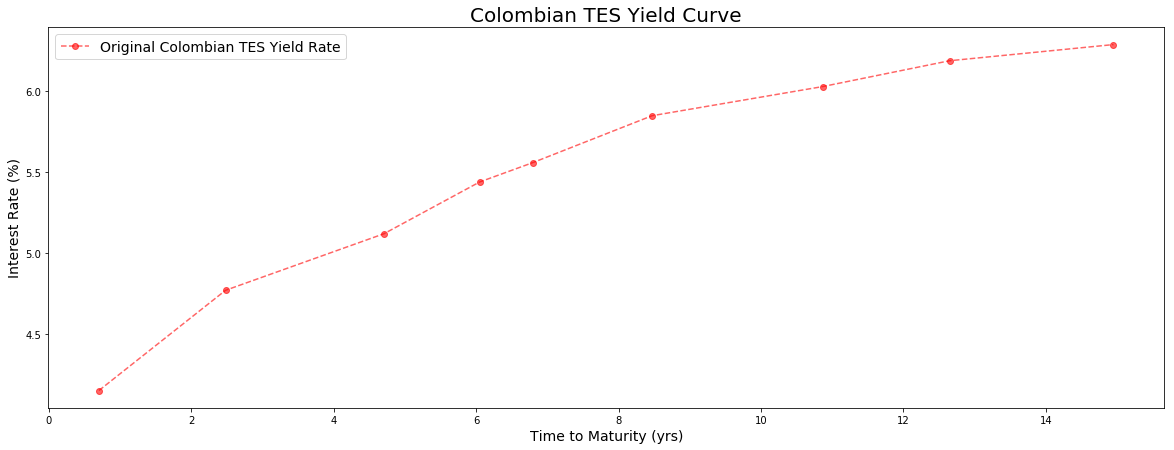

In [11]:
plt.figure(figsize=(20,7))

plt.plot(
    free_risk_bonds['period'],
    free_risk_bonds['yield_rate']*100,
    label='Original Colombian TES Yield Rate',
    linestyle='--',
    marker='o',
    c='red',
    alpha=0.6
)

plt.title('Colombian TES Yield Curve', fontsize=20)
plt.ylabel('Interest Rate (%)', fontsize=14)
plt.xlabel('Time to Maturity (yrs)', fontsize=14)

plt.legend(fontsize=14)
plt.show()

# Parameters

Basically we want to estimate four parameters, called B<sub>0</sub>, B<sub>1</sub>, B<sub>2</sub> and tau (<b><a href="https://education.wbstraining.com/pluginfile.php/4716/mod_resource/content/2/Chaves_Technical%2520Manual%2520Nelson%2520%2520Siegel%2520model.pdf">take a look here</a></b>). This parameters represents some characteristic on term structure of interest rate. 

- <b>B<sub>0</sub></b> : Is the level of long term interest rate in the curve
- <b>B<sub>1</sub></b> : Is the spread between short and long term of interest rate
- <b>B<sub>2</sub></b> : Will be the term where the term structure could have a inflexion point
- <b>Tau</b> : Is  the decay factor in term structure of interest rate, small values produce slow decay while large values produce fast decay

Thus, to this example, we will set this values, based on the chart above, as:
- <b>B<sub>0</sub></b> = 7
- <b>B<sub>1</sub></b> = 4 - 7 = - 3
- <b>B<sub>2</sub></b> = 0, because I don't see some strongest inflexion point
- <b>Tau</b> : 1

In [12]:
first_ = False
free_risk_bonds_first = None

In [13]:
def nelson_and_siegel(x):
    
    b0=x[0]
    b1=x[1]
    b2=x[2]
    tau=x[3]
    
    global free_risk_bonds
    global free_risk_bonds_first
    global first_
    
    for i_, values in free_risk_bonds.iterrows():

        start_date = values['maturity_date'] + relativedelta(years=-30)
        end_date = values['maturity_date']
        coupon_rate = values['coupon_rate']
        default_nominal = 100

        df_coupon_flows = build_coupon_dates(
                                start_date=start_date,
                                frequency='Y',
                                number_periods=1,
                                end_date=end_date,
                                lower_date_threshold=valuation_date
                            )

        df_coupon_flows = pd.DataFrame(df_coupon_flows, columns=['date'])

        df_coupon_flows = build_flows_projection(
                                valuation_date=valuation_date,
                                coupon_rate=coupon_rate,
                                nominal=default_nominal,
                                coupon_dates=df_coupon_flows
                            )

        df_coupon_flows = calculate_initial_nelson_siegel_rate(
                                coupon_flows=df_coupon_flows,
                                b0=b0,
                                b1=b1,
                                b2=b2,
                                tau=tau
                            )

        # ns_flows

        df_coupon_flows = calculate_present_value(flows=df_coupon_flows)

        bond_dirty_price = df_coupon_flows['present_value'].sum()

        # XIRR
        _v_xirr = xirr(
            [(valuation_date.date(), -bond_dirty_price )] + [tuple (i) for i in df_coupon_flows[['date','payment']].values.tolist()]
        )

        free_risk_bonds.loc[i_,'dirty_price'] = bond_dirty_price
        free_risk_bonds.loc[i_,'xirr'] = _v_xirr
    
    if not first_:
        first_ = True
        free_risk_bonds_first = free_risk_bonds.copy()
    
    return root_mean_squared_error(free_risk_bonds['yield_rate'],free_risk_bonds['xirr'])

## Minimizing RMSE
- between observed yield rate and xirr calculated using Nelson and Siegel rates

To get Nelson and Siegel model's parameters, we must to minimize the error between yield rate observed and yield rate in NS's model. To get this I did use root mean squared error <b>(RMSE)</b>. But before, we need to take into account that the model to look a local mimimum, reason why we need to set B0, B1, B2 and tau in some value nearest to original yield curve, as we did.

In [14]:
x0 = np.array([7.0, -3.0, 0.0, 1.0])
res = optimize.minimize(nelson_and_siegel, x0, method='nelder-mead', options={'xtol': 1e-8, 'disp': True})

if res.success:
    res = res.x.tolist()
else:
    raise Exception('Something is wrong! .... What could have been happen? ... '+res.message)

Optimization terminated successfully.
         Current function value: 132.911392
         Iterations: 218
         Function evaluations: 403


In [15]:
print("""
        Nelson and Siegel parameters calculated:
            - B0 \t\t: {b0}
            - B1 \t\t: {b1}
            - B2 \t\t: {b2}
            - tau \t\t: {tau}
    """.format(
        b0 = res[0],
        b1 = res[1],
        b2 = res[2],
        tau = res[3]
    )
)


        Nelson and Siegel parameters calculated:
            - B0 		: 7.677302298888388
            - B1 		: -3.8389432946747624
            - B2 		: -0.012194752502677266
            - tau 		: 5.265190450792611
    


## Plotting

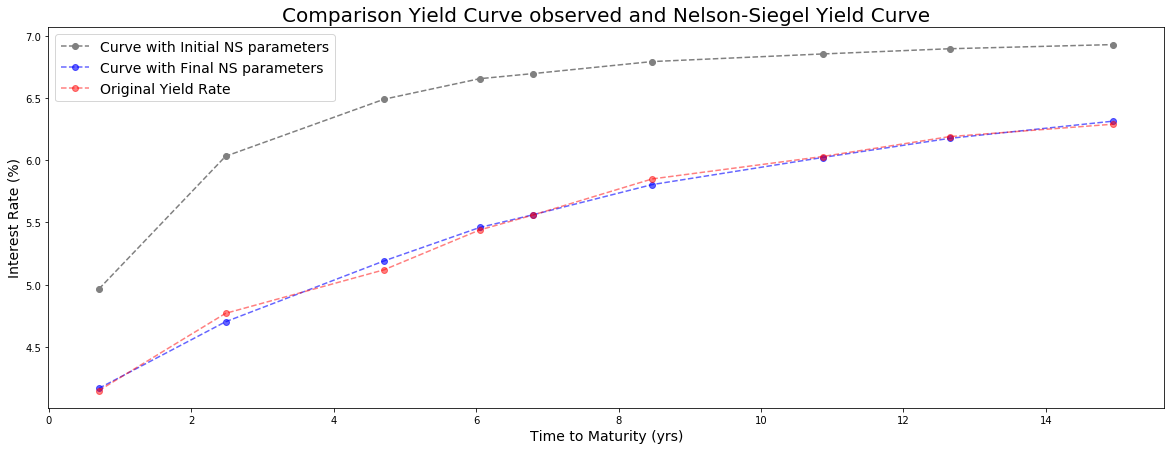

In [16]:
plt.figure(figsize=(20,7))

plt.plot(
    free_risk_bonds_first['period'],
    free_risk_bonds_first['xirr']*100,
    label='Curve with Initial NS parameters',
    linestyle='--',
    marker='o',
    c='gray'
)

plt.plot(
    free_risk_bonds['period'],
    free_risk_bonds['xirr']*100,
    label='Curve with Final NS parameters',
    linestyle='--',
    marker='o',
    c='blue',
    alpha=0.6
)

plt.plot(
    free_risk_bonds['period'],
    free_risk_bonds['yield_rate']*100,
    label='Original Yield Rate',
    linestyle='--',
    marker='o',
    c='red',
    alpha=0.5
)

plt.title('Comparison Yield Curve observed and Nelson-Siegel Yield Curve', fontsize=20)
plt.ylabel('Interest Rate (%)', fontsize=14)
plt.xlabel('Time to Maturity (yrs)', fontsize=14)

plt.legend(fontsize=14)
plt.show()

As we did see above, the line colored as gray represents the term structure using the initial parameters of B<sub>0</sub>, B<sub>1</sub>, B<sub>2</sub> and tau, as 7, -3, 0 and 1, respectively. The line colored light red is observed yield curve.

Nevertheless after minimizing RMSE between observed and NS's yield curve, I did get the line colored as blue, drawn using parameters <b>B<sub>0</sub></b>=7.6773, <b>B<sub>1</sub></b>=-3.8389, <b>B<sub>2</sub></b>=-0.0121 and <b>Tau</b>=5.2651. This parameters let to the term structure of interest rate to be nearest to original yield curve, and for this reason, we could use this to get any interest rate in term structure of spot interest rate throught time without worry about we just have specific nodes in original yield curve.

Its important underline this interest rate is spot, because was used the Nelson and Siegel model after using integration operator.

<hr>

This could not to be the final version, so if you have some recommendation or comment about this, I will be grateful to hear it, using e-mail <b>craquinterogo@unal.edu.co</b> or <b>cristian.quintero@est.uexternado.edu.co</b>

<hr>